#### Python Packages

In [16]:
#All dependencies are managed in requirements.txt
import sqlite3
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt

In [17]:
#Constants 
DB_NAME = 'mock_resq.db'
TABLE_ORDERS = 'orders'
TABLE_PROVIDERS = 'providers'
TABLE_USERS = 'users'
TABLE_DENORM = 'denorm_table'
#Set True to re-run the table creation pipeline
RESTART_PIPELINE = False

#logging setup
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

#### Utility Functions

In [18]:
def connect_db(db_name = DB_NAME):
    """
    Connects to SQLite DB.

    Args:
        db_name (str): DB name to connect with.

    Returns:
        sqlite3.Connection/None: Either a connection object or None in case of connection errors.
    """
    try:
        #establish connection to SQLite database
        conn = sqlite3.connect(db_name)
        return conn
    except Exception as e:
        logging.error(f"An exception occured: {e}")
    
    return None

def execute_query(conn, query):
    """
    Executes DDL queries.

    Args:
        conn (sqlite3.Connection): DB connection object to run queries.
        query (str): SQL query to execute.

    Returns: Returns nothing.
    
    Raises:
        Exception: if query is not valid or could not be executed.
    """
    try:
        conn.execute(query)
    except Exception as e:
        logging.error(f"Query can't be executed: {e}")
        raise

Before creating this table I reviewed the provided database mock_resq.db schema and data using [DB Browser for SQLite](https://sqlitebrowser.org/). After carefully review of the DB and questions that analyst intends to ask I was able to understand that this task is about denormalization of data in favour of analytical workload (A common scenario)
when data from OLTP systems is moved to OLAP systems for running analytical queries.

**Initial Findings:**
- Three tables namely: users, orders, providers
- Users are customers and providers are partners
- Customer Base: 111 different countries
- User Registeration Dates: 2015 and 2023 (Total: 8 years)
- Provider Offer Types: meal, snack, dessert, grocery-bag, ingredients, flowers -- six offer types
- Provider Countries: fin, swe, deu, pol, est
- Total Orders: 300,000 approx
- And a few minor details that I kept checking during my implementation using DB Browser

#### Problem - 1

In [19]:
if RESTART_PIPELINE:
    #connect SQLite DB
    conn = connect_db()
    if not conn:
        logging.error("Could not connect DB")
    else:
        # To Restart the table creation -- execute this cell
        try:
            execute_query(conn, f"Drop Table {TABLE_DENORM}")
        except Exception as e:
            logging.error(f"An exception occured while dropping {TABLE_DENORM}: {e}")

In [ ]:
#Table creation - pipeline

#connect SQLite DB
conn = connect_db()
if not conn:
    logging.error("Could not connect DB")
else:
    """ 
        Create a temporary table with cohort data.
        since cohort month is when the user made its first purchase and 
        later this data will be used to calculate M1 retention therefore
        I am keeping cohort in date format to make downstream comparison with
        order's date (here days are irrelevant).
    """
    cohort_table = "CREATE TABLE user_cohort AS \
                SELECT  userId, MIN(strftime('%Y-%m-01', createdAt)) AS cohort \
                FROM orders GROUP BY  userId;"
    try:
        execute_query(conn, cohort_table)
        logging.info("cohort table created successfully.")
    except Exception as e:
        logging.error(f"Cohort table can't be created: {e}")

    # create denormalized_table table
    table_query = f"CREATE TABLE {TABLE_DENORM} AS \
        SELECT o.id AS order_id, \
        o.createdAt AS order_date, \
        o.userId AS user_id, \
        o.quantity, o.sales, \
        o.currency, o.providerId AS provider_id, \
        p.defaultOfferType AS provider_offer_type,\
        p.country AS provider_country,\
        p.registeredDate AS provider_registered_date,\
        u.country AS user_country,\
        u.registeredDate AS user_registered_date, \
        uc.cohort AS 'user_cohort' \
        FROM orders o \
        JOIN providers p ON o.providerId = p.id \
        JOIN users u ON o.userId = u.id \
        JOIN user_cohort uc ON o.userId = uc.userId;"
    try:
        execute_query(conn, table_query)
        logging.info(f"{TABLE_DENORM} created successfully.")
    except Exception as e:
        logging.error(f"An exception occured while creating {TABLE_DENORM} {e}")

    #Delete temporary table
    try:
        execute_query(conn, "Drop Table user_cohort")
    except Exception as e:
        logging.error(f"An exception occured while dropping cohort table: {e}")


    #Close DB connection -- Release resources
    conn.close()

Analysis Queries (Optional): I used them to validate the implementation.

In [21]:
#connect SQLite DB
conn = connect_db()
if not conn:
    logging.error("Could not connect DB")
else:
    top_10_partners_query = f"select provider_id, sum(sales) as total_sales from {TABLE_DENORM} \
        group by provider_id order by total_sales DESC limit 10"
    top_10_partners = pd.read_sql_query(top_10_partners_query, conn)
    print("Top 10 providers by sale")
    display(top_10_partners)

    fav_partner_segment = f"select provider_offer_type, sum(sales) as 'total_sales' \
                            from {TABLE_DENORM} \
                            group by provider_offer_type order by total_sales DESC"
    fav_partner_segments = pd.read_sql_query(fav_partner_segment, conn)
    print("Favorite Partner Segments: ")
    display(fav_partner_segments)

    #cohort 2022-11 - M1 Retension
    """ 
        I have run a separate query to check total customers 2022-11 and the number was 12,559.
        Based on the analysis only 7234 were retained for the cohort in question.
        The query used: select DISTINCT user_id from denorm_table dt where dt.user_cohort='2022-11-01'
    """
    m1_retention = f"select count(DISTINCT user_id) as 'cohort_size'  from {TABLE_DENORM} \
                    where user_cohort = '2022-11-01' and order_date > date(user_cohort, '+1 month')"
    m1_retention_data = pd.read_sql_query(m1_retention, conn)
    print("2022-11 M1: ")
    display(m1_retention_data)
    conn.close()

Top 10 providers by sale


,provider_id,total_sales
0,7198110370745783236,10917800
1,8312310143652755348,7467750
2,8097235958083241788,2383700
3,3865474760205653333,2223400
4,8084884958338058541,1868140
5,4734853230275691017,1702100
6,5305286819167536850,1690500
7,1066258454353124935,1568100
8,7642201963087705313,1472000
9,4014236829817167297,1457000


Favorite Partner Segments: 


,provider_offer_type,total_sales
0,meal,187308136
1,snack,25307411
2,grocery-bag,15371244
3,dessert,2301810
4,ingredients,738553
5,flowers,58885


2022-11 M1: 


,cohort_size
0,7234


#### Problem - 2

In [22]:
def get_data():
    """
    Connect to SQLite DB and retrieve table as a data frame.
    Column data types are mapped to appropriate python data type
    for better memory utilization and compute performance.

    Returns:
        pd.Dataframe: returns table in a pandas dataframe.

    """
    #connect SQLite DB
    conn = connect_db()
    data_df = None
    if not conn:
        logging.error("Could not connect DB")
    else:
        try:
            column_types = {
                'order_id': np.int64,
                'user_id': np.int64,
                'provider_id': np.int64,
                'quantity': np.uint8,
                'sales': np.uint32,
                'currency': pd.StringDtype(),
                'provider_offer_type': pd.StringDtype(),
                'provider_country': pd.StringDtype(),
                'user_country': pd.StringDtype(),
                'user_cohort': pd.StringDtype()
            }
            data_df = pd.read_sql_query(f"select * from {TABLE_DENORM}", conn, dtype=column_types, parse_dates=['order_date','provider_registered_date','user_registered_date'])
        except Exception as e:
            logging.error(f"Could not read {TABLE_DENORM}. {e}")
        finally:
            conn.close()
        return data_df
    
def get_purchase_frequency(total_orders, total_customers):
    """
    Calculate purchase frequency based on total number of orders
    and unique number of customers.

    Args:
        total_orders (int): total number of orders.
        total_customers (int): total number of customers.

    Returns:
        float: returns purchase frequency.
    """
    purchase_frequency = 0
    if total_customers > 0:
        purchase_frequency = total_orders / total_customers
    return purchase_frequency

def get_average_order_value(total_sales, total_orders):
    """
    Calculate average order value based on total sales
    and number of orders.

    Args:
        total_sales (numpy.uint64): total sales.
        total_orders (int): total number of orders.

    Returns:
        numpy.float64: returns average order value.
    """
    if total_orders > 0:
        avg_order_value = total_sales / total_orders
    return avg_order_value

def get_customer_lifespans(df):
    """
    Calculate customer lifespan based on their first and last purchase dates

    Args:
        df (pd.Dtaframe): denoum_table(DB Table) as a pandas dataframe.

    Returns:
        pd.Series: returns a series of customer lifespans.
    """
    # first and last purchase dates for each user
    customer_lifespan = df.groupby('user_id').agg(
        first_purchase=('order_date', 'min'),
        last_purchase=('order_date', 'max')
    )
    # customer lifespan in days
    customer_lifespans = (pd.to_datetime(customer_lifespan['last_purchase']) -
                                    pd.to_datetime(customer_lifespan['first_purchase'])).dt.days
    
    return customer_lifespans

def calculate_clv(purchase_frequency, average_order_value, average_lifespan):
    """ 
    Calculate CLV: Factors to consider in calculation: purchase frequency, average order value, 
    and average customer lifespan (the time between customers' first and last purchase)

    Args:
        purchase_frequency (float): calculated purchase frequency.
        average_order_value (numpy.float64): calculated average order value
        average_lifespan (numpy.float64): calculate customer average lifespan

    Returns:
        numpy.float64: returns customer lifetime value (CLV).
    """
    #expected CLV
    clv = purchase_frequency * average_order_value * average_lifespan
    return clv

def replace_outliers_with_percentile(data, percentile=90):
    nth_percentile = np.nanpercentile(sorted(data), percentile)
    return np.where(data > nth_percentile, nth_percentile, data)

#### Calculate customer lifetime value

In [23]:

data_df = get_data()
if not data_df.empty:
    total_orders = data_df['order_id'].nunique()
    unique_customers = data_df['user_id'].nunique()
    #calculate purchase frequency
    purchase_frequency = get_purchase_frequency(total_orders, unique_customers)
    #average order value
    total_sales = data_df['sales'].sum()
    average_order_value = get_average_order_value(total_sales, total_orders)

    #average customer lifespan
    customer_lifespans = get_customer_lifespans(data_df)
    average_lifespan = customer_lifespans.mean()

    #calculate clv
    clv = calculate_clv(purchase_frequency, average_order_value, average_lifespan)

    print(f"Estimated CLV: {clv:.2f}")

Estimated CLV: 144367.84


**Remarks:**

Estimated value seems too big. On Further investigation, I figured sales has few outliers that are making the
value too big. I stopped the implementation here assuming the purpose of the assignment is assessing coding
style. However, there are many other factors that should be considered to get a correct value of CLV for instance
average life span may also contain outliers if a user's order are too far apart. Similarly profitability and churn rate can also be calculated and incorporated in the formula. I have seen in my initial analysis sales value does not represent 
single currency value (SEK, EUR) so a better idea would be to first fix these discrepencies in the data and then do CLV calculations. 

Overall, I enjoyed solving the assignment and reading about some new concepts regarding insight analytics and CLV.

In [24]:
# To see outliers in sales variable
data_df['sales'].describe()

count    299971.000000
mean        770.361265
std        1505.639471
min           0.000000
25%         350.000000
50%         550.000000
75%         800.000000
max      102500.000000
Name: sales, dtype: float64

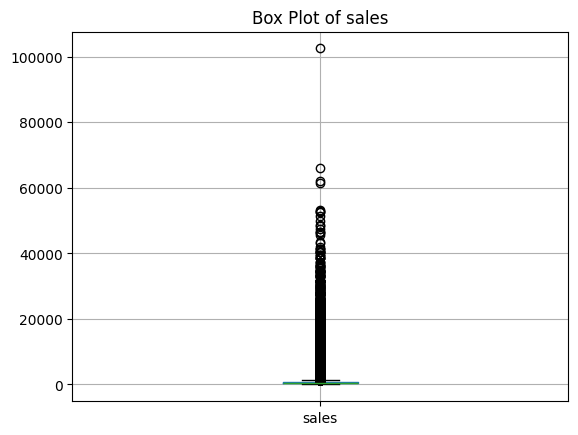

In [25]:
data_df.boxplot(column='sales')
plt.title('Box Plot of sales')
plt.show()

In [27]:
""" 
    One potential solution to eliminate outliers in sales is to use highest possible percentile 
    (inspired by winsorization) and replace outliers to get a better estimate of CLV.
"""
data_df['sales'] = replace_outliers_with_percentile(data_df['sales'], percentile=98)

"""
    Since I followed a modular approach, it is possible to address the discrepencies in a data preprocessing
    step iteratively and evaluate the CLV value for better estimate. 
"""
#re-calculate average order value
total_sales = data_df['sales'].sum()
average_order_value = get_average_order_value(total_sales, total_orders)

clv = calculate_clv(purchase_frequency, average_order_value, average_lifespan)
print(f"Estimated CLV: {clv:.2f}")

count    299971.000000
mean        655.924026
std         514.270169
min           0.000000
25%         350.000000
50%         550.000000
75%         800.000000
max        2746.440000
Name: sales, dtype: float64

Estimated CLV: 122921.98
